In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import numpy as np
import cv2
import pandas as pd
import xmltodict
import json
import glob
import os
import sys

torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()
if torch.cuda.get_device_properties(0).major >= 8:
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    
checkpoint = "../segment-anything-2/checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"
predictor = SAM2ImagePredictor(build_sam2(model_cfg, checkpoint))

In [11]:
def load_annotations (data_path):
    """
    Load the annotations extracted from CVAT

    Parameters:
        path: path to the annotation file which is a xml file
    Returns:
        The CVAT xml file in a dictionary
    """
    with open(os.path.join(data_path, "annotations.xml")) as f:
        dataset = xmltodict.parse(f.read())
    return dataset

def extract_data_from_cvat_annotations (data_path):
    """
    Extract data from CVAT annotation xml file

    Parameters:
        data_path: path to the annotation file which is a xml file
    Returns:
        A dictionary of image names, images, bounding boxes and their corresponding classes
    """
    dataset = load_annotations (data_path)
    number_of_images = len(dataset['annotations']['image'])
    DATA_DICT = dict()
    for INDEX in range(number_of_images):
        annotations = dataset['annotations']['image'][INDEX]
        classes_list = []
        image_name = annotations['@name']
        print(image_name)
        img = cv2.imread(os.path.join(data_path, "task_0/data", image_name))
        mask = np.zeros((img.shape[0],img.shape[1]))
        try:
            image_boxes_data = annotations['box']
        except:
            image_boxes_data = []
        # checks if there is any bounding box in the frame; otherwise it returns an empty mask for that frame without any class names
        frame_data_dict= dict()
        if len(image_boxes_data)==0:
            frame_data_dict.update({
                "image_name": image_name,
                "img": img,
                "classes": [],
                "boxes": []
            })
        else:
            boxes = [[float(image_boxes_data[j]['@xtl']), float(image_boxes_data[j]['@ytl']), float(image_boxes_data[j]['@xbr']),float(image_boxes_data[j]['@ybr'])] for j in range(len(image_boxes_data))]
            # labels = [image_boxes_data[j]["attribute"]['#text'] for j in range(len(image_boxes_data))]
            labels = []
            for j in range(len(image_boxes_data)):
                if image_boxes_data[j]['@label'] != 'Rock' and image_boxes_data[j]['@label'] != 'Unknown':
                    labels.append(image_boxes_data[j]["attribute"]['#text'])
            frame_data_dict.update({
                "image_name": image_name,
                "img": img,
                "classes": labels,
                "boxes": boxes,
            })
        DATA_DICT.update({INDEX : frame_data_dict })
    return DATA_DICT


data_path = "images"
dataset_dict = extract_data_from_cvat_annotations(data_path)

Deepwatercove_001.png
Deepwatercove_009.png
Deepwatercove_017.png
Deepwatercove_025.png
Deepwatercove_033.png
Deepwatercove_041.png
Deepwatercove_049.png
Deepwatercove_057.png
Deepwatercove_065.png
Deepwatercove_073.png
Deepwatercove_081.png
Deepwatercove_089.png
Deepwatercove_097.png
Deepwatercove_105.png
Deepwatercove_113.png
Deepwatercove_121.png
Deepwatercove_129.png
Deepwatercove_137.png
Deepwatercove_145.png
Deepwatercove_153.png
Deepwatercove_161.png
Deepwatercove_169.png
Deepwatercove_177.png
Deepwatercove_185.png
Deepwatercove_193.png
Deepwatercove_201.png
Deepwatercove_209.png
Deepwatercove_217.png
Deepwatercove_225.png
Deepwatercove_233.png
Deepwatercove_241.png
Deepwatercove_249.png
Deepwatercove_257.png
Deepwatercove_265.png
Deepwatercove_273.png
Deepwatercove_281.png
Deepwatercove_289.png
Deepwatercove_297.png
Deepwatercove_305.png
Deepwatercove_313.png
Deepwatercove_321.png
Deepwatercove_329.png
Deepwatercove_337.png
Deepwatercove_345.png
Deepwatercove_353.png
Deepwaterc

AttributeError: 'NoneType' object has no attribute 'shape'

In [21]:
out_put_path = "pseudo_labels"
if not os.path.exists(out_put_path):
    os.makedirs(out_put_path)

INDEX = 8
img_name = dataset_dict[INDEX]["image_name"]
save_frame_path = os.path.join(out_put_path,img_name[:-4])
if not os.path.exists(save_frame_path):
    os.mkdir(os.path.join(save_frame_path))
cv2.imwrite(os.path.join(save_frame_path,img_name),dataset_dict[INDEX]["img"].copy())

boxes_ = dataset_dict[INDEX]["boxes"]
if len(boxes_)==0:
    print("No bounding box in this frame: ", img_name)
    exit # change this to "continue" if you have added the loop for all the images
classes_ = dataset_dict[INDEX]["classes"]
unique_class_names = list(np.unique(classes_))
for unique_c in unique_class_names:
    boxes = [boxes_[index] for index, value in enumerate(classes_) if value == unique_c]
    classes = [classes_[index] for index, value in enumerate(classes_) if value == unique_c]
    img = dataset_dict[INDEX]["img"].copy()
    sam_img = img.copy()
    mask = np.zeros((img.shape[0],img.shape[1]))
    sam_input_points = []
    sam_input_labels = []
    
    ############################################ Sam2 Annotator ############################################
    def mouse_callback(event, x, y, flags, param):
        global dataset_dict,sam_input_points,sam_input_labels, img, mask, sam_img
        if event == cv2.EVENT_LBUTTONDOWN:
            sam_input_points.append((x, y))
            sam_input_labels.append([1])
            cv2.circle(img, (x, y), 5, (0, 255, 0), -1)  # Green color for positive points
            sam_img =  dataset_dict[INDEX]["img"].copy()
            predictor.reset_predictor()
            predictor.set_image(sam_img)
            masks, scores, logits = predictor.predict(
                point_coords=np.asarray(sam_input_points),
                point_labels=np.asarray(sam_input_labels).reshape(len(sam_input_labels,)),
                multimask_output=False)
            mask = masks[0]
            
        elif event == cv2.EVENT_RBUTTONDOWN:
            sam_input_points.append((x, y))
            sam_input_labels.append([0])
            cv2.circle(img, (x, y), 5, (0, 0, 255), -1)  # Red color for negative points
            sam_img =  dataset_dict[INDEX]["img"].copy()
            masks, scores, logits = predictor.predict(
                point_coords=np.asarray(sam_input_points),
                point_labels=np.asarray(sam_input_labels).reshape(len(sam_input_labels,)),
                multimask_output=False)
            mask = masks[0].astype(np.uint8) 
        if len(sam_input_points)!=0:
            colored_mask = cv2.cvtColor(mask * 255, cv2.COLOR_GRAY2BGR).astype(np.uint8) 
            img = cv2.addWeighted(sam_img.copy(), 0.9, colored_mask, 0.7, 0)    
        cv2.imshow('Image', img)
        
    cv2.namedWindow('Image')
    cv2.setMouseCallback('Image', mouse_callback)
    while True:
        for box in boxes:
            img = cv2.rectangle(img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0,0,255),1)
        cv2.imshow('Image', img)
        key = cv2.waitKey(1) & 0xFF
        if key == 27:  # ESC key to break
            break
        if key == ord("r"):
            sam_input_points = []
            sam_input_labels = []
            positive_points = []
            negative_points = []
    cv2.destroyAllWindows()
    ############################################ Editor ############################################
    radius = 5
    drawing = False
    value = 255
    # Mouse callback function to edit the mask
    def mouse_callback_editor(event, x, y, flags, param):
        global alpha,colored_mask,img, mask_, radius, drawing, value
    
        if event == cv2.EVENT_LBUTTONDOWN:
            drawing = True
            value = 255
            mask_ = cv2.circle(mask_, (x, y), radius, value, -1)
            colored_mask = cv2.cvtColor(mask_, cv2.COLOR_GRAY2BGR).astype(np.uint8) 
            img = cv2.addWeighted(imgg.copy(), alpha, colored_mask, 0.7, 0)    
    
        elif event == cv2.EVENT_RBUTTONDOWN:
            drawing = True
            value = 0
            mask_ = cv2.circle(mask_, (x, y), radius, value, -1)
            colored_mask = cv2.cvtColor(mask_, cv2.COLOR_GRAY2BGR).astype(np.uint8) 
            img = cv2.addWeighted(imgg.copy(), alpha, colored_mask, 0.7, 0)  
        elif event == cv2.EVENT_MOUSEMOVE:
            if drawing:
                mask_ = cv2.circle(mask_, (x, y), radius, value, -1)
                colored_mask = cv2.cvtColor(mask_, cv2.COLOR_GRAY2BGR).astype(np.uint8) 
                img = cv2.addWeighted(imgg.copy(), alpha, colored_mask, 0.7, 0)  
        elif event == cv2.EVENT_LBUTTONUP or event == cv2.EVENT_RBUTTONUP:
            drawing = False
        cv2.imshow('Mask', img)
    
    mask_ = (mask*255).astype(np.uint8)
    
    imgg = dataset_dict[INDEX]["img"].copy()
    colored_mask = cv2.cvtColor(mask_, cv2.COLOR_GRAY2BGR).astype(np.uint8) 
    alpha = 0.7
    while(True):
        img = cv2.addWeighted(imgg.copy(), alpha, colored_mask, 0.7, 0)
        cv2.imshow('Mask', img)
        cv2.setMouseCallback('Mask', mouse_callback_editor)
        key = cv2.waitKey(0) & 0xFF
        if key == ord("1"):
            radius=10
        if key == ord("2"):
            radius=20
        if key == ord("3"):
            radius=30  
        if key == ord("f"):
            if alpha+0.1<=1:
                alpha+=0.1
        if key == ord("d"):
            if alpha-0.1>=0:
                alpha-=0.1
        if key == 27:
            break
    cv2.destroyAllWindows()
    
    #################### save results ####################
    cv2.imwrite(os.path.join(save_frame_path,unique_c+".png"),(mask_).astype(np.uint8))
    
    
    ################## post processing ###################
    saved_mask_pp = cv2.medianBlur(mask_, 11)
    _, saved_mask_pp = cv2.threshold(saved_mask_pp, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.array([[0, 1, 1, 1, 0],
                       [1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1],
                       [0, 1, 1, 1, 0]], np.uint8)

    saved_mask_pp = cv2.erode(saved_mask_pp, kernel, iterations=2)
    saved_mask_pp = cv2.dilate(saved_mask_pp, kernel, iterations=3)
    
    cv2.imwrite(f"{save_frame_path}\\{unique_c}-pp.png", (saved_mask_pp).astype(np.uint8))

## Post Processing

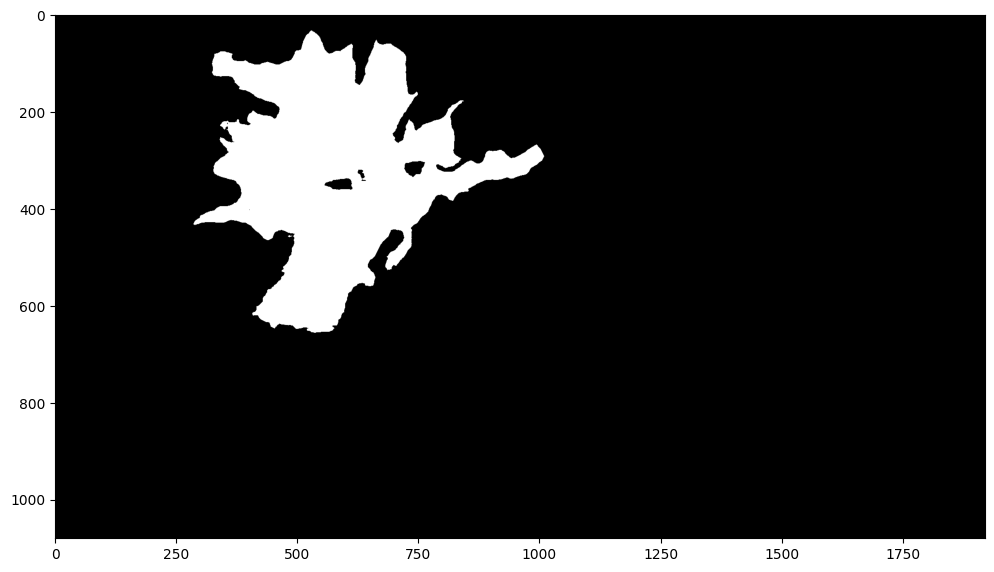

In [4]:
saved_mask_path = f"{save_frame_path}\\{unique_c}.png"
saved_mask = cv2.imread(saved_mask_path, cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(12, 10))
plt.imshow(saved_mask, cmap='gray')
plt.show()

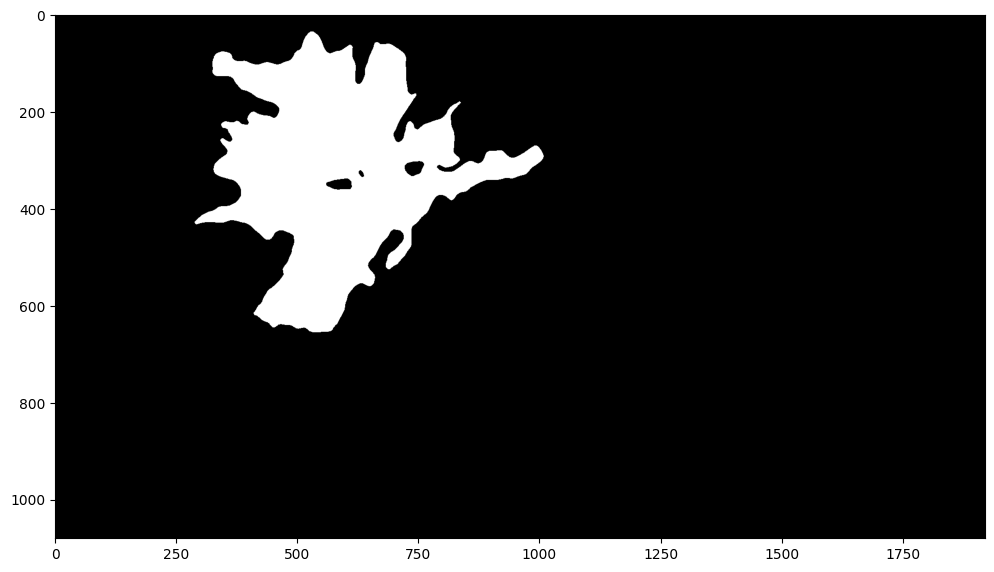

In [5]:
saved_mask_pp = cv2.medianBlur(saved_mask, 11)
plt.figure(figsize=(12, 10))
plt.imshow(saved_mask_pp, cmap='gray')
plt.show()

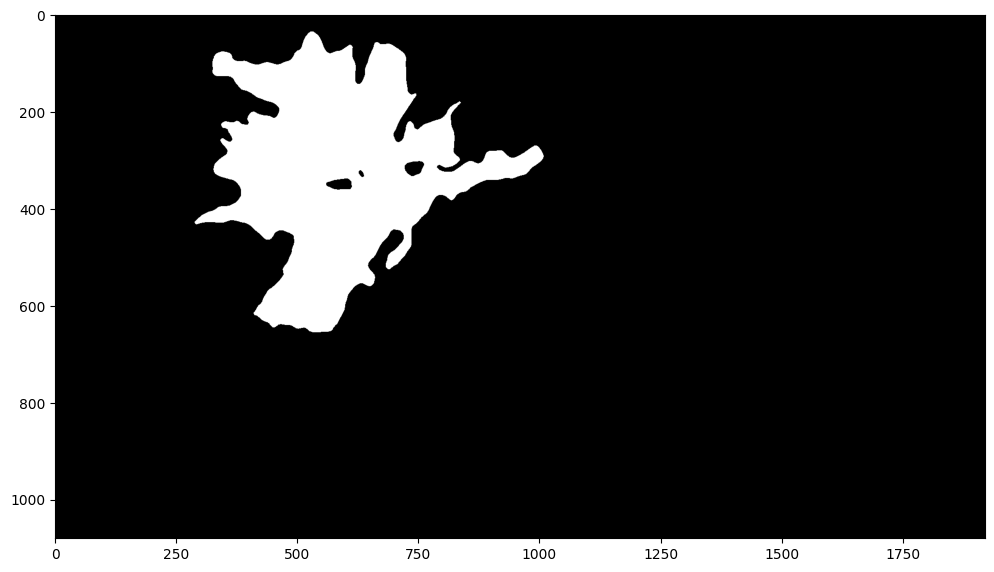

In [6]:
_, saved_mask_pp = cv2.threshold(saved_mask_pp, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.figure(figsize=(12, 10))
plt.imshow(saved_mask_pp, cmap='gray')
plt.show()

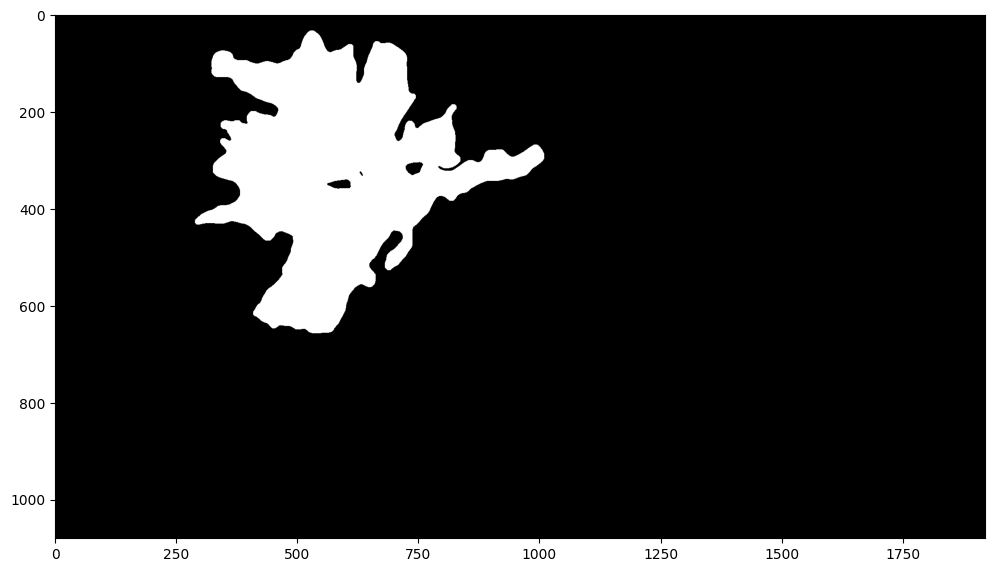

In [7]:
kernel = np.array([[0, 1, 1, 1, 0],
                   [1, 1, 1, 1, 1],
                   [1, 1, 1, 1, 1],
                   [1, 1, 1, 1, 1],
                   [0, 1, 1, 1, 0]], np.uint8)

saved_mask_pp = cv2.erode(saved_mask_pp, kernel, iterations=2)
saved_mask_pp = cv2.dilate(saved_mask_pp, kernel, iterations=3)
plt.figure(figsize=(12, 10))
plt.imshow(saved_mask_pp, cmap='gray')
plt.show()

In [8]:
cv2.imwrite(f"{save_frame_path}\\{unique_c}-pp.png", (saved_mask_pp).astype(np.uint8))

True